### Implementing The Difference In Difference Estimator

Analysis on mock education policy implemented in a specific region on student performance. The policy was introduced in 2022, aiming to improve the quality of education in public schools. Data from 2019 to 2023 for both the treated region (where the policy was implemented) and a control region (where the policy was not implemented).

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import scipy.stats
import statsmodels as sm
import statsmodels.formula.api as smf

In [3]:
student_data = pd.read_csv('student_performance_data_DID.csv')
student_data.head(-1)

,year,region,students_performance
0,2019,control,73.652969
1,2019,control,72.430664
2,2019,control,67.759575
3,2019,control,74.221611
4,2019,control,78.163910
...,...,...,...
2994,2023,treated,77.409981
2995,2023,treated,70.771416
2996,2023,treated,73.878273
2997,2023,treated,82.847946


In [4]:
student_data_treat = student_data[student_data['region']=='treated']
student_data_treat.describe()


,year,students_performance
count,1500.000000,1500.000000
mean,2021.000000,75.994631
std,1.414685,5.002108
min,2019.000000,58.793663
25%,2020.000000,72.468807
50%,2021.000000,75.969734
75%,2022.000000,79.362047
max,2023.000000,94.263657


In [5]:
student_data_control = student_data[student_data['region']=='control']
student_data_control.describe()

,year,students_performance
count,1500.000000,1500.000000
mean,2021.000000,75.173377
std,1.414685,4.945111
min,2019.000000,60.044319
25%,2020.000000,71.947338
50%,2021.000000,75.115673
75%,2022.000000,78.402507
max,2023.000000,94.631187


Plot showing the average student performance over time for both regions to visually inspect the parallel trends assumption.


Text(0, 0.5, 'average student performance')

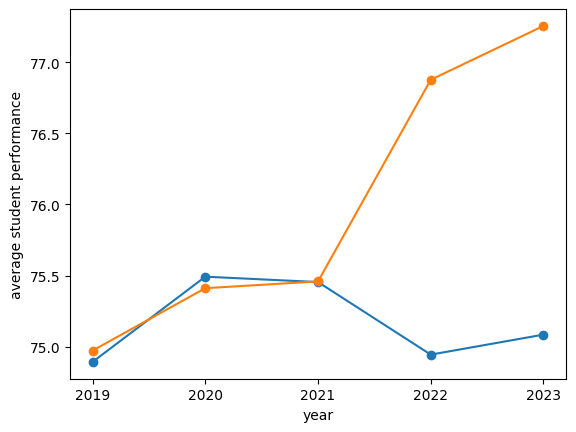

In [21]:
print('Plot showing the average student performance over time for both regions to visually inspect the parallel trends assumption.')
control_performance = student_data_control.groupby('year').mean(numeric_only=True)
treatment_performance = student_data_treat.groupby('year').mean(numeric_only=True)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(tck.MultipleLocator())
ax.plot(control_performance, 'o-')
ax.plot(treatment_performance, 'o-')

ax.set_xlabel('year')
ax.set_ylabel('average student performance')

Text(0.5, 1.0, 'Control Group Performance')

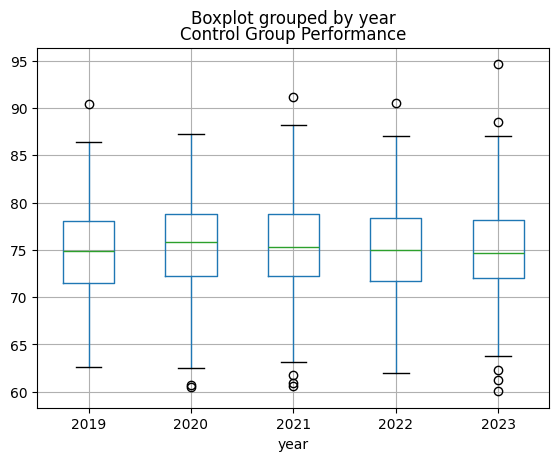

In [7]:
fig3, ax2 = plt.subplots() 
control_graph = student_data_control.boxplot(column='students_performance', by='year', ax=ax2)
plt.title('Control Group Performance')

Text(0.5, 1.0, 'Treatment Group Performance')

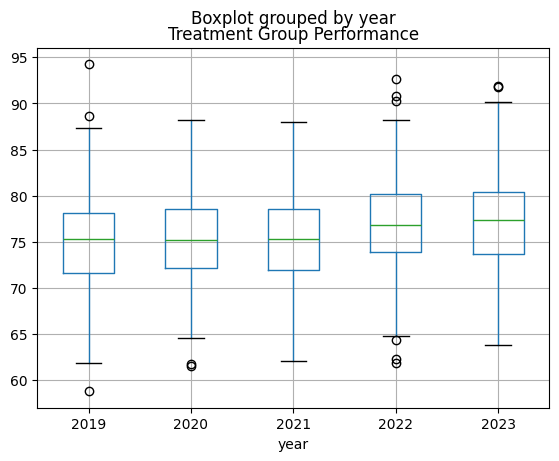

In [8]:
fig3, ax2 = plt.subplots() 
treatment_graph = student_data_treat.boxplot(column='students_performance', by='year', ax=ax2)
plt.title('Treatment Group Performance')

In [22]:
print('Dummy variable for the post-treatment period (post), which is 1 for years 2022 and 2023, and 0 otherwise.')
student_data[['2019','2020','2021','2022','2023']] = pd.get_dummies(student_data['year'], dtype=float)
student_data['post']= student_data['2022'] + student_data['2023']
student_data

Dummy variable for the post-treatment period (post), which is 1 for years 2022 and 2023, and 0 otherwise.


,year,region,students_performance,2019,2020,2021,2022,2023,post,control,treat,post_treat
0,2019,control,73.652969,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2019,control,72.430664,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2019,control,67.759575,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2019,control,74.221611,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2019,control,78.163910,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2023,treated,70.771416,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2996,2023,treated,73.878273,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2997,2023,treated,82.847946,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2998,2023,treated,77.429466,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [19]:
print('Dummy variable for the treated region (treated), which is 1 for the treated region and 0 for the control region.')

student_data[['control','treat']] = pd.get_dummies(student_data['region'], dtype=float)
student_data['post_treat'] = student_data['treat'] * student_data['post']
student_data.head(-10)

Created a dummy variable for the treated region (treated), which is 1 for the treated region and 0 for the control region.


,year,region,students_performance,2019,2020,2021,2022,2023,post,control,treat,post_treat
0,2019,control,73.652969,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2019,control,72.430664,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2019,control,67.759575,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2019,control,74.221611,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2019,control,78.163910,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2985,2023,treated,72.694557,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2986,2023,treated,79.986137,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2987,2023,treated,73.081169,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2988,2023,treated,75.909767,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [25]:
print('Computed the difference-in-differences estimator to find estimate of treatment efficacy')
did = smf.ols('students_performance ~ treat + post + post_treat', data=student_data).fit()
print(did.summary())

Computed the difference-in-differences estimator to find estimate of treatment efficacy
                             OLS Regression Results                             
Dep. Variable:     students_performance   R-squared:                       0.022
Model:                              OLS   Adj. R-squared:                  0.021
Method:                   Least Squares   F-statistic:                     22.96
Date:                  Mon, 13 Jan 2025   Prob (F-statistic):           1.08e-14
Time:                          22:14:12   Log-Likelihood:                -9044.4
No. Observations:                  3000   AIC:                         1.810e+04
Df Residuals:                      2996   BIC:                         1.812e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

Conclusion: The model suggests there is a statistically significant difference in differences among the treatment students in the two years post experiment period. From the analysis it appears that students who went through the treatment group, received a post experiment average grade that was 2.05 points higher than our control group.
